In [21]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
dataset2 = pd.read_csv('Tweets.csv')
dataset2.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [23]:
dataset1 = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=["sentiment", "id", "date", "flag", "user", "text"])
dataset1 = dataset1[['text', 'sentiment']]
dataset1['sentiment'] = dataset1['sentiment'].replace(0, "negative")
dataset1['sentiment'] = dataset1['sentiment'].replace(4, "postive")
dataset1 = dataset1.dropna(axis=0, how="any")
dataset1.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,is upset that he can't update his Facebook by ...,negative
2,@Kenichan I dived many times for the ball. Man...,negative
3,my whole body feels itchy and like its on fire,negative
4,"@nationwideclass no, it's not behaving at all....",negative


In [24]:
dataset2 = pd.read_csv('Tweets.csv')
dataset2 = dataset2[['text', 'sentiment']]
dataset2 = dataset2[dataset2['sentiment'] != "neutral"]
dataset2 = dataset2.dropna(axis=0, how="any")
dataset2.head()

,text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
6,2am feedings for the baby are fun when he is a...,positive


In [25]:
dataset3 = pd.read_csv('twitter_training.csv', names=["id", "entity", "sentiment", "text"])
dataset3 = dataset3[['text', 'sentiment']]
dataset3['sentiment'] = dataset3['sentiment'].str.lower()
dataset3 = dataset3[dataset3['sentiment'] != "neutral"]
dataset3 = dataset3[dataset3['sentiment'] != "irrelevant"]
dataset3 = dataset3.dropna(axis=0, how="any")

dataset3.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,positive
1,I am coming to the borders and I will kill you...,positive
2,im getting on borderlands and i will kill you ...,positive
3,im coming on borderlands and i will murder you...,positive
4,im getting on borderlands 2 and i will murder ...,positive


In [26]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [27]:
def preprocessText(text):
    processedText = []

    wordLemm = WordNetLemmatizer()

    for tweet in text:
        # Lower Casing
        tweet = tweet.lower()

        # Replacing URL
        tweet = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", ' URL', tweet)

        # Replacing Emoji
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        # Replacing Usernames
        tweet = re.sub("@[^\s]+", " USER", tweet)

        # Removing Non-alphabets
        tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)

        # Removing Consecutive letters
        tweet = re.sub(r"(.)\1\1", r"\1\1", tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwordlist:
                if len(word) > 1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')

        processedText.append(tweetwords)
    return processedText

In [28]:
preprocessText1 = preprocessText(dataset1['text'])
preprocessText2 = preprocessText(dataset2['text'])
preprocessText3 = preprocessText(dataset3['text'])

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(preprocessText1, dataset1['sentiment'], test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(preprocessText2, dataset2['sentiment'], test_size=0.2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(preprocessText3, dataset3['sentiment'], test_size=0.2)

In [30]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectoriser.fit(X_train1)
X_train1 = vectoriser.transform(X_train1)
X_test1 = vectoriser.transform(X_test1)

vectoriser.fit(X_train2)
X_train2 = vectoriser.transform(X_train2)
X_test2 = vectoriser.transform(X_test2)

vectoriser.fit(X_train3)
X_train3 = vectoriser.transform(X_train3)
X_test3 = vectoriser.transform(X_test3)

In [31]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)

    print(classification_report(y, y_pred))

    confusion = confusion_matrix(y, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in confusion.flatten() / np.sum(confusion)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(confusion, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title("Confusion Matrix")

In [32]:
BNBmodel = BernoulliNB(alpha = 2)
SVCmodel = LinearSVC()
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
RFmodel = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=1000)

              precision    recall  f1-score   support

    negative       0.84      0.81      0.82    639671
     postive       0.82      0.84      0.83    640329

    accuracy                           0.83   1280000
   macro avg       0.83      0.83      0.83   1280000
weighted avg       0.83      0.83      0.83   1280000



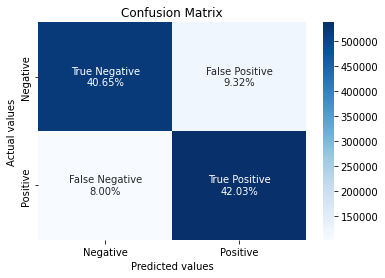

In [33]:
BNBmodel.fit(X_train1, y_train1)
evaluate_model(BNBmodel, X_train1, y_train1)

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79    160329
     postive       0.79      0.81      0.80    159671

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



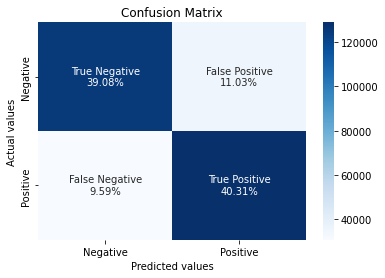

In [34]:
evaluate_model(BNBmodel, X_test1, y_test1)

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92      6269
    positive       0.88      1.00      0.93      6821

    accuracy                           0.93     13090
   macro avg       0.94      0.92      0.93     13090
weighted avg       0.94      0.93      0.93     13090



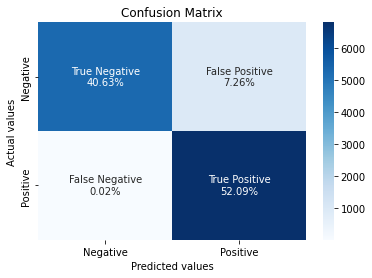

In [35]:
BNBmodel.fit(X_train2, y_train2)
evaluate_model(BNBmodel, X_train2, y_train2)

              precision    recall  f1-score   support

    negative       0.98      0.37      0.54      1512
    positive       0.65      0.99      0.78      1761

    accuracy                           0.71      3273
   macro avg       0.81      0.68      0.66      3273
weighted avg       0.80      0.71      0.67      3273



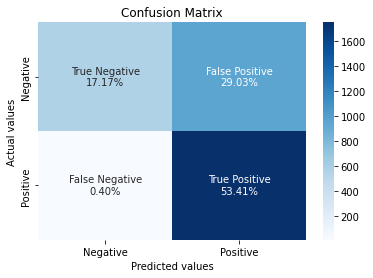

In [36]:
evaluate_model(BNBmodel, X_test2, y_test2)

              precision    recall  f1-score   support

    negative       0.99      0.91      0.95     17835
    positive       0.92      0.99      0.95     16575

    accuracy                           0.95     34410
   macro avg       0.95      0.95      0.95     34410
weighted avg       0.96      0.95      0.95     34410



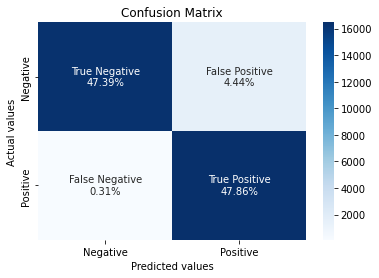

In [37]:
BNBmodel.fit(X_train3, y_train3)
evaluate_model(BNBmodel, X_train3, y_train3)

              precision    recall  f1-score   support

    negative       0.98      0.87      0.92      4523
    positive       0.87      0.98      0.92      4080

    accuracy                           0.92      8603
   macro avg       0.93      0.93      0.92      8603
weighted avg       0.93      0.92      0.92      8603



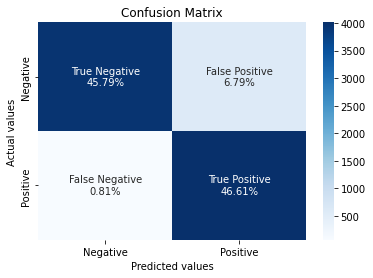

In [38]:
evaluate_model(BNBmodel, X_test3, y_test3)

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90    639671
     postive       0.90      0.91      0.90    640329

    accuracy                           0.90   1280000
   macro avg       0.90      0.90      0.90   1280000
weighted avg       0.90      0.90      0.90   1280000



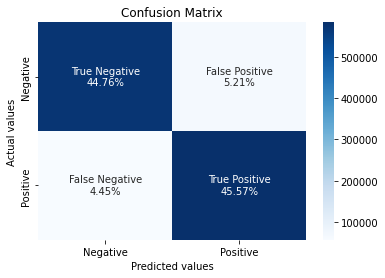

In [39]:
SVCmodel.fit(X_train1, y_train1)
evaluate_model(SVCmodel, X_train1, y_train1)

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80    160329
     postive       0.79      0.81      0.80    159671

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



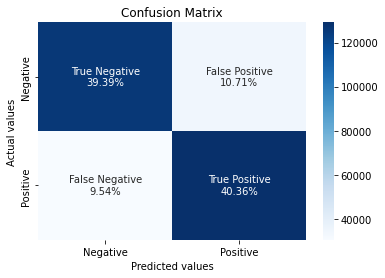

In [40]:
evaluate_model(SVCmodel, X_test1, y_test1)

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      6269
    positive       1.00      1.00      1.00      6821

    accuracy                           1.00     13090
   macro avg       1.00      1.00      1.00     13090
weighted avg       1.00      1.00      1.00     13090



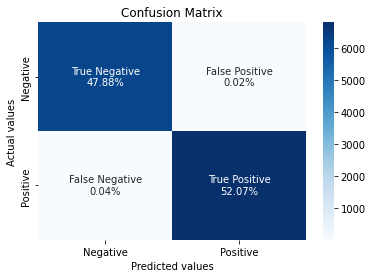

In [41]:
SVCmodel.fit(X_train2, y_train2)
evaluate_model(SVCmodel, X_train2, y_train2)

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      1512
    positive       0.88      0.89      0.89      1761

    accuracy                           0.88      3273
   macro avg       0.88      0.88      0.88      3273
weighted avg       0.88      0.88      0.88      3273



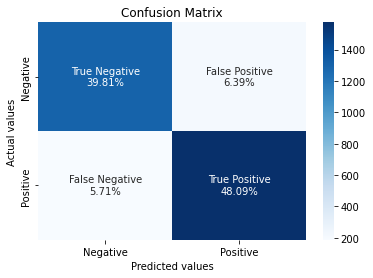

In [42]:
evaluate_model(SVCmodel, X_test2, y_test2)

              precision    recall  f1-score   support

    negative       0.99      0.97      0.98     17835
    positive       0.97      0.99      0.98     16575

    accuracy                           0.98     34410
   macro avg       0.98      0.98      0.98     34410
weighted avg       0.98      0.98      0.98     34410



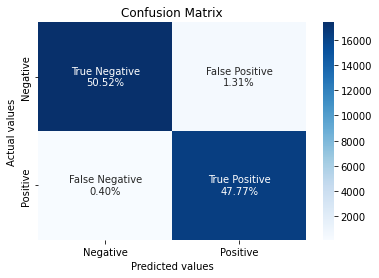

In [43]:
SVCmodel.fit(X_train3, y_train3)
evaluate_model(SVCmodel, X_train3, y_train3)

              precision    recall  f1-score   support

    negative       0.97      0.95      0.96      4523
    positive       0.95      0.97      0.96      4080

    accuracy                           0.96      8603
   macro avg       0.96      0.96      0.96      8603
weighted avg       0.96      0.96      0.96      8603



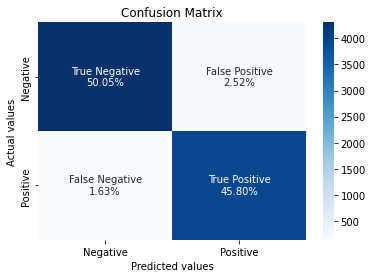

In [44]:
evaluate_model(SVCmodel, X_test3, y_test3)

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86    639671
     postive       0.86      0.87      0.87    640329

    accuracy                           0.86   1280000
   macro avg       0.86      0.86      0.86   1280000
weighted avg       0.86      0.86      0.86   1280000



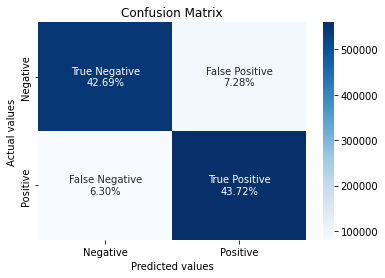

In [46]:
LRmodel.fit(X_train1, y_train1)
evaluate_model(LRmodel, X_train1, y_train1)

              precision    recall  f1-score   support

    negative       0.82      0.80      0.81    160329
     postive       0.80      0.82      0.81    159671

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



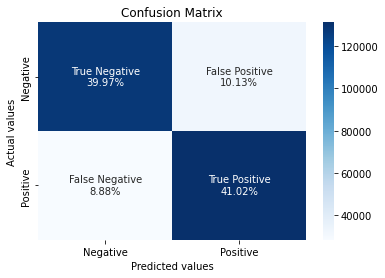

In [47]:
evaluate_model(LRmodel, X_test1, y_test1)

              precision    recall  f1-score   support

    negative       0.98      0.99      0.99      6269
    positive       0.99      0.98      0.99      6821

    accuracy                           0.99     13090
   macro avg       0.99      0.99      0.99     13090
weighted avg       0.99      0.99      0.99     13090



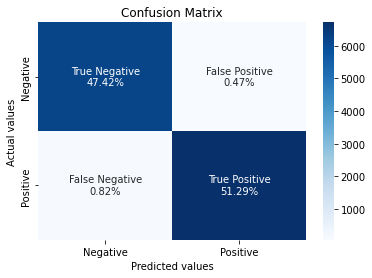

In [48]:
LRmodel.fit(X_train2, y_train2)
evaluate_model(LRmodel, X_train2, y_train2)

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      1512
    positive       0.88      0.88      0.88      1761

    accuracy                           0.87      3273
   macro avg       0.87      0.87      0.87      3273
weighted avg       0.87      0.87      0.87      3273



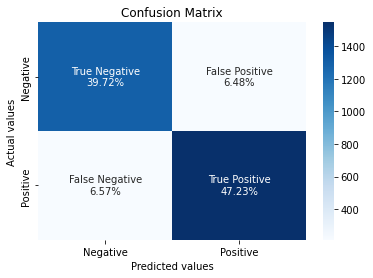

In [49]:
evaluate_model(LRmodel, X_test2, y_test2)

              precision    recall  f1-score   support

    negative       0.96      0.99      0.98     17835
    positive       0.99      0.96      0.97     16575

    accuracy                           0.97     34410
   macro avg       0.97      0.97      0.97     34410
weighted avg       0.97      0.97      0.97     34410



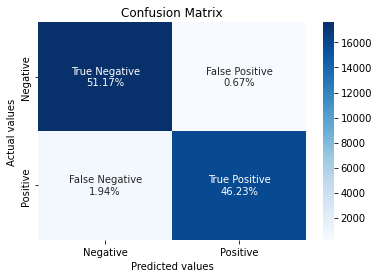

In [50]:
LRmodel.fit(X_train3, y_train3)
evaluate_model(LRmodel, X_train3, y_train3)

              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      4523
    positive       0.95      0.91      0.93      4080

    accuracy                           0.93      8603
   macro avg       0.94      0.93      0.93      8603
weighted avg       0.93      0.93      0.93      8603



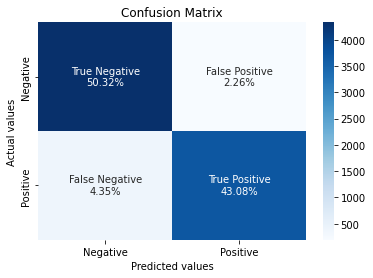

In [51]:
evaluate_model(LRmodel, X_test3, y_test3)

              precision    recall  f1-score   support

    negative       0.79      0.59      0.68    639671
     postive       0.67      0.85      0.75    640329

    accuracy                           0.72   1280000
   macro avg       0.73      0.72      0.71   1280000
weighted avg       0.73      0.72      0.71   1280000



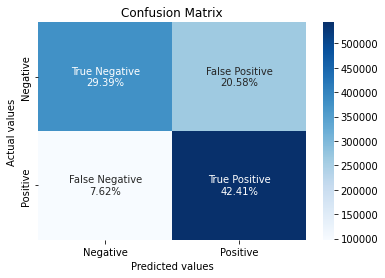

In [52]:
RFmodel.fit(X_train1, y_train1)
evaluate_model(RFmodel, X_train1, y_train1)

              precision    recall  f1-score   support

    negative       0.80      0.58      0.67    160329
     postive       0.67      0.85      0.75    159671

    accuracy                           0.72    320000
   macro avg       0.73      0.72      0.71    320000
weighted avg       0.73      0.72      0.71    320000



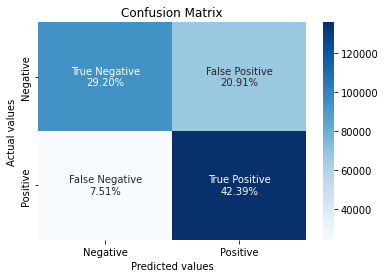

In [53]:
evaluate_model(RFmodel, X_test1, y_test1)

c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      6269
    positive       0.52      1.00      0.69      6821

    accuracy                           0.52     13090
   macro avg       0.26      0.50      0.34     13090
weighted avg       0.27      0.52      0.36     13090



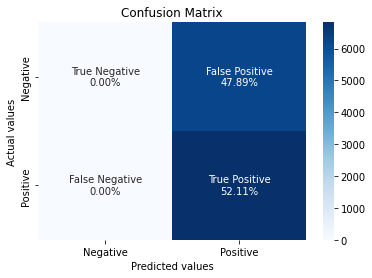

In [54]:
RFmodel.fit(X_train2, y_train2)
evaluate_model(RFmodel, X_train2, y_train2)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1512
    positive       0.54      1.00      0.70      1761

    accuracy                           0.54      3273
   macro avg       0.27      0.50      0.35      3273
weighted avg       0.29      0.54      0.38      3273



c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nattawut\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

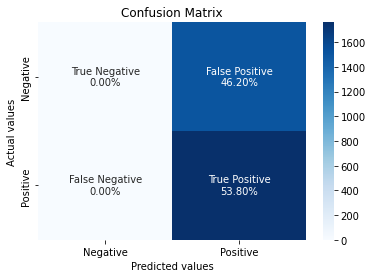

In [55]:
evaluate_model(RFmodel, X_test2, y_test2)

              precision    recall  f1-score   support

    negative       0.52      1.00      0.68     17835
    positive       1.00      0.00      0.00     16575

    accuracy                           0.52     34410
   macro avg       0.76      0.50      0.34     34410
weighted avg       0.75      0.52      0.36     34410



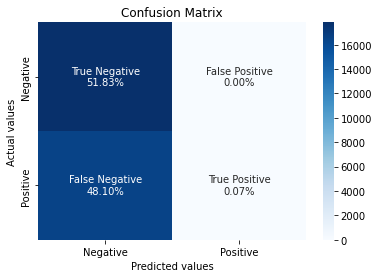

In [56]:
RFmodel.fit(X_train3, y_train3)
evaluate_model(RFmodel, X_train3, y_train3)

              precision    recall  f1-score   support

    negative       0.53      1.00      0.69      4523
    positive       1.00      0.00      0.00      4080

    accuracy                           0.53      8603
   macro avg       0.76      0.50      0.35      8603
weighted avg       0.75      0.53      0.36      8603



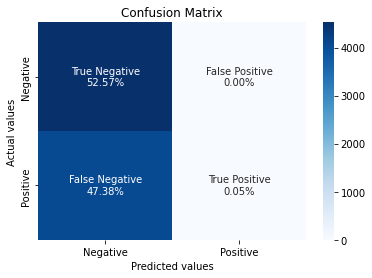

In [57]:
evaluate_model(RFmodel, X_test3, y_test3)